In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from abtem import *

# Effect of temperature with frozen phonons

The atoms in any real material at a particular instance of time are not exactly located at their symmetrical lattice points due to thermal and zero-point vibrations. The frozen phonon approximation is a simple if somewhat brute-force approach to numerically simulate the effects of thermal vibrations in the specimen. The generated image or diffraction pattern is the intensity averaged over several different configurations of atoms with different random offsets. This type of scattering may be referred to as thermal diffuse scattering or simply TDS.

We will simulate strontium titanate [100] with TDS. In order to observe visible Kikuchi lines, the sample needs a certain thickness, hence we repeat the unit cell 30 times along the z-direction.

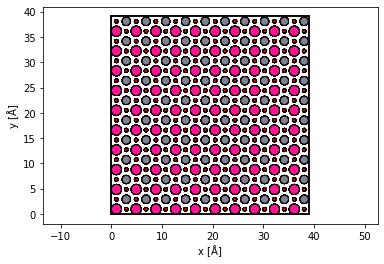

In [8]:
atoms = read('data/srtio3_100.cif')

atoms *= (10, 10, 30)
atoms.center()

show_atoms(atoms)

The `FrozenPhonon` class generates offsets from a Gaussian distribution (equivalent to the Einstein model of the density of states for phonons) using a random number generator with a given seed. The standard deviation of the Gaussian distribution is provided for each element as a dictionary.

In [9]:
frozen_phonons = FrozenPhonons(atoms, 1, {'Sr' : .1, 'Ti' : .1, 'O' : .1}, seed=1)

Below, we generate and show one of the frozen phonon configurations; differences are especially noticeable for the light O atoms.

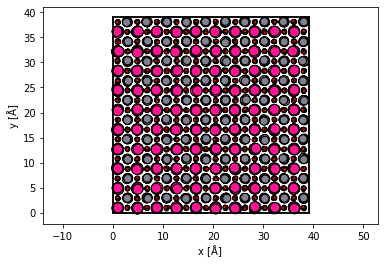

In [10]:
atoms_conf = next(iter(frozen_phonons))

show_atoms(atoms_conf)

We then create a potential for these thermal-displaced configurations.

In [11]:
potential = Potential(frozen_phonons, sampling=.05)

potential.grid.snap_to_power(2)

We then run a multislice simulation for an incoming plane wave of 300 keV energy. Note that the time estimate after the first TDS configuration is overestimated by an order of magnitude as the cache of potential integrals is getting filled.

In [12]:
from abtem.waves import PlaneWave

wave = PlaneWave(energy=300e3, device='cpu')

exit_wave = wave.multislice(potential)

In [21]:
exit_wave.array.shape

(1, 1024, 1024)

In [22]:
patterns = exit_wave.diffraction_pattern()

patterns.mean(0).array.shape

(512, 512)

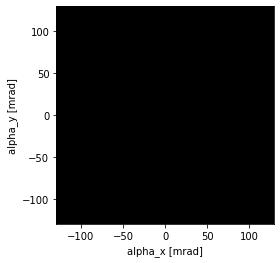

In [17]:
patterns[0].show(log_scale=True, vmax=20);

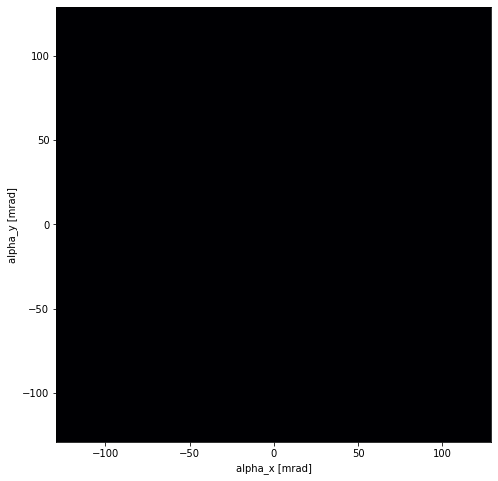

In [24]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
patterns.mean(0).show(log_scale=True, vmax=15, cmap='inferno', ax=ax);

#ax.axis('off')

#ax.set_xlim([-.15,.15])
#ax.set_ylim([-.15,.15])

## STEM with TDS

Simulating (4D)-STEM with TDS is simple.

In [33]:
from ase.io import read
from abtem.scan import LineScan
from abtem.detect import AnnularDetector
from abtem.waves import Probe
from abtem.measure import Measurement
from abtem.potentials import Potential
from abtem.temperature import FrozenPhonons

atoms = read('data/orthogonal_graphene.cif') * (3, 2, 1)
atoms.center(vacuum=3,axis=2)

potential = Potential(FrozenPhonons(atoms, 5, {'C':.1}, seed=7), sampling=.02)

linescan = LineScan(start=[4.06, 0], end=[4.06, 4.06], gpts=10)

probe = Probe(energy=300e3, semiangle_cutoff=.03, focal_spread=60, defocus=50, device='cpu')
haadf = AnnularDetector(inner=.09, outer=.2)

#potential.show(scans=linescan)

In [34]:
measurements = probe.scan(linescan, [haadf], potential, max_batch=1, pbar=True)

IndexError: list index out of range

In [35]:
#ax=Measurement.read('linescan.hdf5').show()
measurements[haadf].show()
#print(ax)

NameError: name 'measurements' is not defined

In [36]:
from tqdm.notebook import tqdm
import time

pbar1 = tqdm(total=10)
pbar2 = tqdm(total=10)

for i in range(10):
    time.sleep(.1)
    pbar1.update(1)
    for j in range(10):
        time.sleep(.1)
        pbar2.update(1)
    pbar2.reset()